<a href="https://colab.research.google.com/github/Fikaaw/amazing-feat-eng/blob/main/bandung_slowmo_hyperparametered_xgb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, KFold, GroupKFold
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression, f_regression, r_regression, GenericUnivariateSelect
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor, Lasso
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from statsmodels.tsa.deterministic import DeterministicProcess, Fourier, CalendarFourier
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import eli5
from eli5.sklearn import PermutationImportance
import holidays

import optuna
import sys
import shutil
import os
import warnings
warnings.filterwarnings('ignore')
sys.path.insert(0, '/kaggle/input/parallel-bandung-slowmo-additional-data')
from data_pipe import data_pipe

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Data Importing and Additional Test

In [ ]:
train_df = pd.read_csv('/kaggle/input/ristek-datathon-2023/train.csv')
additional_df = pd.read_csv('/kaggle/input/parallel-bandung-slowmo-additional-data/Additional_Train.csv')
train_df = pd.concat([train_df, additional_df], axis = 1)
test_df = pd.read_csv('/kaggle/input/ristek-datathon-2023/test.csv')
additional_test = pd.read_csv('/kaggle/input/parallel-bandung-slowmo-additional-data/Additional_Test.csv')
test_df = pd.concat([test_df, additional_test], axis = 1)
sub = pd.read_csv('/kaggle/input/ristek-datathon-2023/sample_submission.csv')

# Data Information

In [ ]:
print(train_df.dtypes)
print(test_df.dtypes)
print(train_df.isna().sum())
print(test_df.isna().sum())

waktu_setempat       object
id_jalan              int64
id_titik_mulai        int64
id_titik_akhir        int64
rerata_kecepatan    float64
ref                  object
maxspeed             object
highway              object
name                 object
start_lat           float64
start_lon           float64
end_lat             float64
end_lon             float64
dtype: object
id                  int64
waktu_setempat     object
id_jalan            int64
id_titik_mulai      int64
id_titik_akhir      int64
ref                object
maxspeed           object
highway            object
name               object
start_lat         float64
start_lon         float64
end_lat           float64
end_lon           float64
dtype: object
waktu_setempat      0
id_jalan            0
id_titik_mulai      0
id_titik_akhir      0
rerata_kecepatan    0
ref                 0
maxspeed            0
highway             0
name                0
start_lat           0
start_lon           0
end_lat             0
end_lo

# Dropping Useless Variable

In [ ]:
ids = [c for c in train_df.columns if 'id' in c]
train_df.drop(ids + ['name'], axis = 1, inplace = True)
test_df.drop(ids + ['id', 'name'], axis = 1, inplace = True)

In [ ]:
train_df

,waktu_setempat,rerata_kecepatan,ref,maxspeed,highway,start_lat,start_lon,end_lat,end_lon
0,2020-02-01 01:00:00+00:00,29.126,A24,30 mph,trunk,51.434928,-0.161176,51.434975,-0.161090
1,2020-02-01 01:00:00+00:00,46.576,A1000,30 mph,primary,51.623990,-0.176398,51.623811,-0.176424
2,2020-02-01 01:00:00+00:00,36.587,B237,20 mph,secondary,51.452530,-0.152437,51.452749,-0.151896
3,2020-02-01 01:00:00+00:00,34.063,A3036,20 mph,primary,51.465851,-0.154188,51.465654,-0.155334
4,2020-02-01 01:00:00+00:00,38.336,A404,30 mph,primary,51.530289,-0.228343,51.530197,-0.227949
...,...,...,...,...,...,...,...,...,...
398643,2020-02-22 23:00:00+00:00,41.094,A205,30 mph,trunk,51.462964,-0.226977,51.463144,-0.228229
398644,2020-02-22 23:00:00+00:00,45.902,A205,30 mph,trunk,51.463517,-0.230807,51.463546,-0.231004
398645,2020-02-22 23:00:00+00:00,38.918,A24,30 mph,trunk,51.455145,-0.145316,51.455635,-0.144829
398646,2020-02-22 23:00:00+00:00,34.951,A404,30 mph,primary,51.530407,-0.228608,51.530697,-0.229246


In [ ]:
test_df

,waktu_setempat,ref,maxspeed,highway,start_lat,start_lon,end_lat,end_lon
0,2020-02-23 00:00:00+00:00,A205,30 mph,trunk,51.465182,-0.255240,51.465204,-0.254595
1,2020-02-23 00:00:00+00:00,A24,30 mph,trunk,51.458973,-0.141882,51.459254,-0.141646
2,2020-02-23 00:00:00+00:00,B237,20 mph,secondary,51.449437,-0.160688,51.449295,-0.161060
3,2020-02-23 00:00:00+00:00,A24,30 mph,trunk,51.457325,-0.143228,51.457466,-0.143110
4,2020-02-23 00:00:00+00:00,A23,30 mph,trunk,51.467314,-0.112842,51.466309,-0.113371
...,...,...,...,...,...,...,...,...
127484,2020-02-29 23:00:00+00:00,A404,30 mph,primary,51.527905,-0.215960,51.528154,-0.216580
127485,2020-02-29 23:00:00+00:00,A4201,20 mph,primary,51.528494,-0.144328,51.527678,-0.144314
127486,2020-02-29 23:00:00+00:00,A1000,30 mph,primary,51.623530,-0.176457,51.623565,-0.176454
127487,2020-02-29 23:00:00+00:00,B237,20 mph,secondary,51.450322,-0.157508,51.450464,-0.157015


# Re-tuning variable

In [ ]:
train_df['maxspeed'] = train_df['maxspeed'].apply(lambda x : x.replace('mph', '').strip()).astype(int)
train_df['ref_letter'] = train_df['ref'].apply(lambda x : x[0])

test_df['maxspeed'] = test_df['maxspeed'].apply(lambda x : x.replace('mph', '').strip()).astype(int)
test_df['ref_letter'] = test_df['ref'].apply(lambda x : x[0])

In [ ]:
train_df.drop('ref', axis = 1, inplace = True)
test_df.drop('ref', axis = 1, inplace = True)

In [ ]:
display(train_df, test_df)

,waktu_setempat,rerata_kecepatan,maxspeed,highway,start_lat,start_lon,end_lat,end_lon,ref_letter
0,2020-02-01 01:00:00+00:00,29.126,30,trunk,51.434928,-0.161176,51.434975,-0.161090,A
1,2020-02-01 01:00:00+00:00,46.576,30,primary,51.623990,-0.176398,51.623811,-0.176424,A
2,2020-02-01 01:00:00+00:00,36.587,20,secondary,51.452530,-0.152437,51.452749,-0.151896,B
3,2020-02-01 01:00:00+00:00,34.063,20,primary,51.465851,-0.154188,51.465654,-0.155334,A
4,2020-02-01 01:00:00+00:00,38.336,30,primary,51.530289,-0.228343,51.530197,-0.227949,A
...,...,...,...,...,...,...,...,...,...
398643,2020-02-22 23:00:00+00:00,41.094,30,trunk,51.462964,-0.226977,51.463144,-0.228229,A
398644,2020-02-22 23:00:00+00:00,45.902,30,trunk,51.463517,-0.230807,51.463546,-0.231004,A
398645,2020-02-22 23:00:00+00:00,38.918,30,trunk,51.455145,-0.145316,51.455635,-0.144829,A
398646,2020-02-22 23:00:00+00:00,34.951,30,primary,51.530407,-0.228608,51.530697,-0.229246,A


,waktu_setempat,maxspeed,highway,start_lat,start_lon,end_lat,end_lon,ref_letter
0,2020-02-23 00:00:00+00:00,30,trunk,51.465182,-0.255240,51.465204,-0.254595,A
1,2020-02-23 00:00:00+00:00,30,trunk,51.458973,-0.141882,51.459254,-0.141646,A
2,2020-02-23 00:00:00+00:00,20,secondary,51.449437,-0.160688,51.449295,-0.161060,B
3,2020-02-23 00:00:00+00:00,30,trunk,51.457325,-0.143228,51.457466,-0.143110,A
4,2020-02-23 00:00:00+00:00,30,trunk,51.467314,-0.112842,51.466309,-0.113371,A
...,...,...,...,...,...,...,...,...
127484,2020-02-29 23:00:00+00:00,30,primary,51.527905,-0.215960,51.528154,-0.216580,A
127485,2020-02-29 23:00:00+00:00,20,primary,51.528494,-0.144328,51.527678,-0.144314,A
127486,2020-02-29 23:00:00+00:00,30,primary,51.623530,-0.176457,51.623565,-0.176454,A
127487,2020-02-29 23:00:00+00:00,20,secondary,51.450322,-0.157508,51.450464,-0.157015,B


# Index Dating Format

In [ ]:
train_df['waktu_setempat'] = pd.to_datetime(train_df['waktu_setempat'])
test_df['waktu_setempat'] = pd.to_datetime(test_df['waktu_setempat'])

In [ ]:
train_df = train_df.set_index('waktu_setempat').to_period('H')
test_df = test_df.set_index('waktu_setempat').to_period('H')

In [ ]:
train_df

,rerata_kecepatan,maxspeed,highway,start_lat,start_lon,end_lat,end_lon,ref_letter
waktu_setempat,,,,,,,,
2020-02-01 01:00,29.126,30,trunk,51.434928,-0.161176,51.434975,-0.161090,A
2020-02-01 01:00,46.576,30,primary,51.623990,-0.176398,51.623811,-0.176424,A
2020-02-01 01:00,36.587,20,secondary,51.452530,-0.152437,51.452749,-0.151896,B
2020-02-01 01:00,34.063,20,primary,51.465851,-0.154188,51.465654,-0.155334,A
2020-02-01 01:00,38.336,30,primary,51.530289,-0.228343,51.530197,-0.227949,A
...,...,...,...,...,...,...,...,...
2020-02-22 23:00,41.094,30,trunk,51.462964,-0.226977,51.463144,-0.228229,A
2020-02-22 23:00,45.902,30,trunk,51.463517,-0.230807,51.463546,-0.231004,A
2020-02-22 23:00,38.918,30,trunk,51.455145,-0.145316,51.455635,-0.144829,A


In [ ]:
y = train_df.pop('rerata_kecepatan')
y

waktu_setempat
2020-02-01 01:00    29.126
2020-02-01 01:00    46.576
2020-02-01 01:00    36.587
2020-02-01 01:00    34.063
2020-02-01 01:00    38.336
                     ...  
2020-02-22 23:00    41.094
2020-02-22 23:00    45.902
2020-02-22 23:00    38.918
2020-02-22 23:00    34.951
2020-02-22 23:00    40.949
Freq: H, Name: rerata_kecepatan, Length: 398648, dtype: float64

# Visualizations

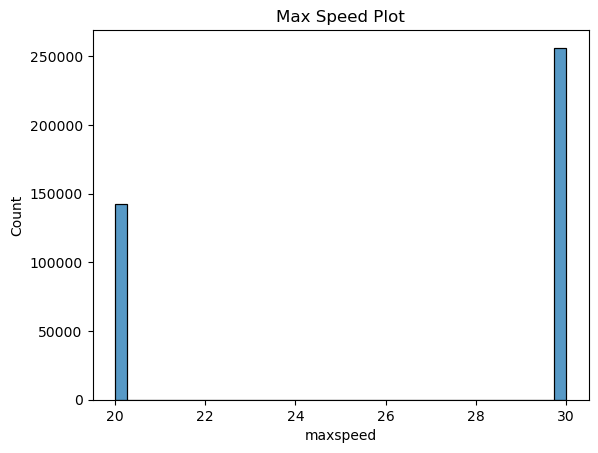

In [ ]:
sns.histplot(train_df['maxspeed'])
plt.title('Max Speed Plot')
plt.show()

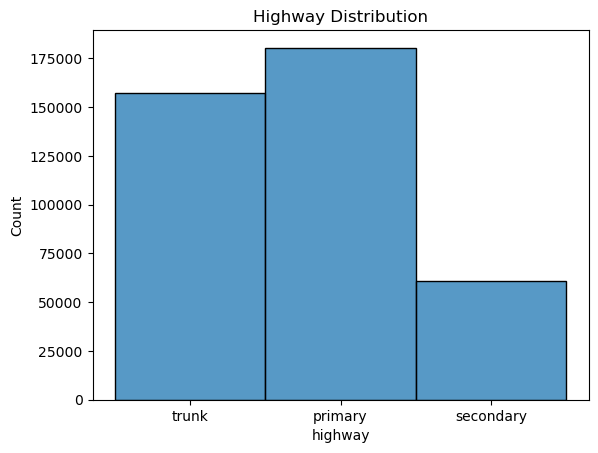

In [ ]:
sns.histplot(train_df['highway'])
plt.title('Highway Distribution')
plt.show()

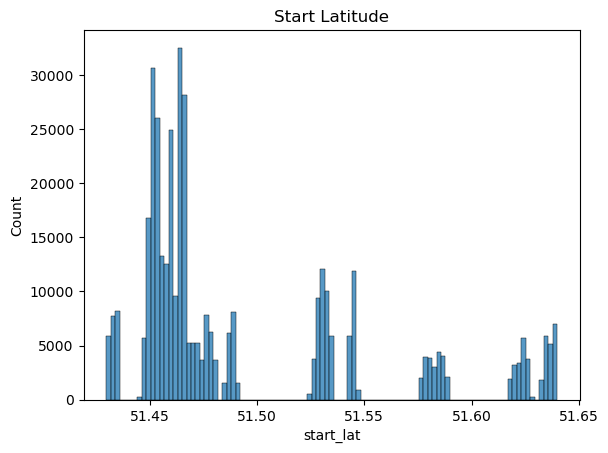

In [ ]:
sns.histplot(train_df['start_lat'])
plt.title('Start Latitude')
plt.show()

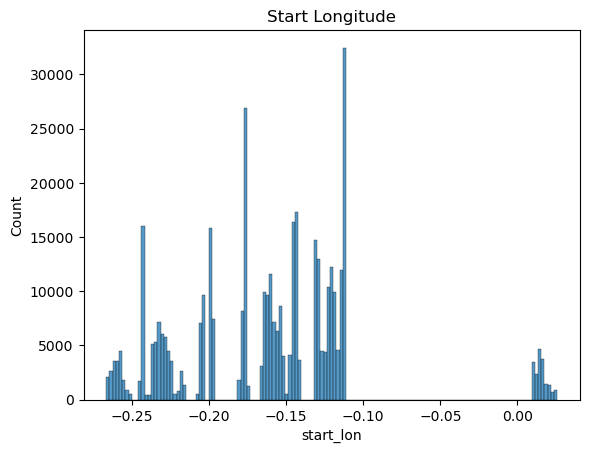

In [ ]:
sns.histplot(train_df['start_lon'])
plt.title('Start Longitude')
plt.show()

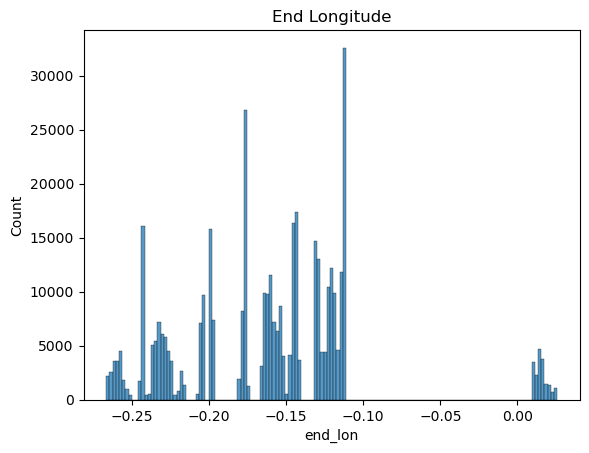

In [ ]:
sns.histplot(train_df['end_lon'])
plt.title('End Longitude')
plt.show()

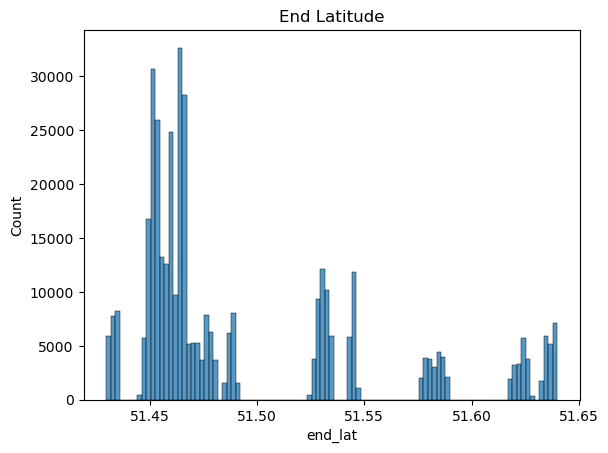

In [ ]:
sns.histplot(train_df['end_lat'])
plt.title('End Latitude')
plt.show()

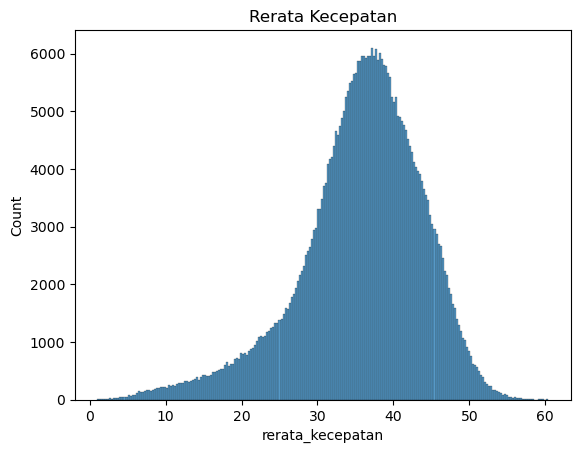

In [ ]:
sns.histplot(y)
plt.title('Rerata Kecepatan')
plt.show()

In [ ]:
train_df.index[0].to_timestamp()

Timestamp('2020-02-01 01:00:00')

In [ ]:
y.loc[y.index[0]]

waktu_setempat
2020-02-01 01:00    29.126
2020-02-01 01:00    46.576
2020-02-01 01:00    36.587
2020-02-01 01:00    34.063
2020-02-01 01:00    38.336
                     ...  
2020-02-01 01:00    34.167
2020-02-01 01:00    37.493
2020-02-01 01:00    45.980
2020-02-01 01:00    37.400
2020-02-01 01:00    47.503
Freq: H, Name: rerata_kecepatan, Length: 894, dtype: float64

<Axes: xlabel='waktu_setempat', ylabel='rerata_kecepatan'>

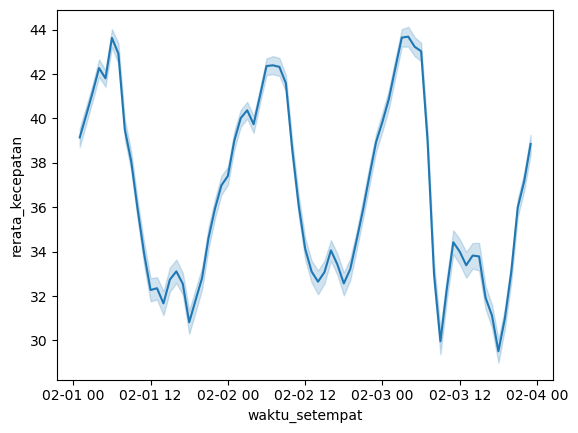

In [ ]:
sns.lineplot(x = train_df.loc[:'2020-02-03'].index.to_timestamp(), y = y.loc[:'2020-02-03'])

# Correlation

In [ ]:
pd.get_dummies(train_df).corrwith(y).sort_values(ascending = False)

end_lat              0.223953
start_lat            0.223864
maxspeed             0.205995
ref_letter_A         0.164055
highway_trunk        0.060317
highway_primary      0.059399
start_lon           -0.052340
end_lon             -0.052344
highway_secondary   -0.164055
ref_letter_B        -0.164055
dtype: float64

In [ ]:
mi_score = mutual_info_regression(pd.get_dummies(train_df), y, random_state = 0)
mi_score = pd.Series(
    mi_score,
    index = pd.get_dummies(train_df).columns
).sort_values(ascending = False)
mi_score

end_lon              0.322456
end_lat              0.301333
start_lon            0.292764
start_lat            0.273784
maxspeed             0.074374
highway_secondary    0.029718
ref_letter_B         0.029677
ref_letter_A         0.028630
highway_trunk        0.016540
highway_primary      0.005474
dtype: float64

In [ ]:
fregress = GenericUnivariateSelect(score_func = f_regression).fit(pd.get_dummies(train_df), y)
fregress_score = pd.Series(
    fregress.scores_,
    index = fregress.feature_names_in_
).sort_values(ascending = False)
fregress_score

end_lat              21049.826875
start_lat            21032.128846
maxspeed             17665.769066
highway_secondary    11025.931168
ref_letter_B         11025.931168
ref_letter_A         11025.931168
highway_trunk         1455.608725
highway_primary       1411.475635
end_lon               1095.247965
start_lon             1095.080730
dtype: float64

In [ ]:
fregress = GenericUnivariateSelect(score_func = r_regression).fit(pd.get_dummies(train_df), y)
fregress_score = pd.Series(
    fregress.scores_,
    index = fregress.feature_names_in_
).sort_values(ascending = False)
fregress_score

end_lat              0.223953
start_lat            0.223864
maxspeed             0.205995
ref_letter_A         0.164055
highway_trunk        0.060317
highway_primary      0.059399
start_lon           -0.052340
end_lon             -0.052344
highway_secondary   -0.164055
ref_letter_B        -0.164055
dtype: float64

In [ ]:
xtrain = pd.get_dummies(train_df).loc[:'2020-02-16']
ytrain = y.loc[:'2020-02-16']
xval = pd.get_dummies(train_df).loc['2020-02-17':]
yval = y.loc['2020-02-17':]

In [ ]:
perm = PermutationImportance(Ridge(alpha = .5), cv = 5).fit(pd.get_dummies(train_df), y)
eli5.show_weights(perm, feature_names = pd.get_dummies(train_df).columns.tolist())

Weight,Feature
0.1674 ± 0.0355,end_lat
0.0839 ± 0.0191,highway_trunk
0.0440 ± 0.0133,highway_primary
0.0409 ± 0.0104,start_lat
0.0400 ± 0.0076,maxspeed
0.0038 ± 0.0025,ref_letter_A
0.0038 ± 0.0025,highway_secondary
0.0036 ± 0.0029,ref_letter_B
0.0015 ± 0.0041,start_lon
0.0001 ± 0.0028,end_lon


# Feature Engineering

In [ ]:
train_df['manhattan_distance'] = np.abs(train_df['start_lat'] - train_df['end_lat']) + np.abs(train_df['start_lon'] - train_df['end_lon'])
train_df['euclidean_distance'] = np.sqrt(np.square(train_df['start_lat'] - train_df['end_lat']) + np.square(train_df['start_lon'] - train_df['end_lon']))

test_df['manhattan_distance'] = np.abs(test_df['start_lat'] - test_df['end_lat']) + np.abs(test_df['start_lon'] - test_df['end_lon'])
test_df['euclidean_distance'] = np.sqrt(np.square(test_df['start_lat'] - test_df['end_lat']) + np.square(test_df['start_lon'] - test_df['end_lon']))

In [ ]:
pd.get_dummies(train_df).corrwith(y).sort_values(ascending = False)

end_lat               0.223953
start_lat             0.223864
maxspeed              0.205995
ref_letter_A          0.164055
highway_trunk         0.060317
highway_primary       0.059399
start_lon            -0.052340
end_lon              -0.052344
euclidean_distance   -0.092110
manhattan_distance   -0.096343
highway_secondary    -0.164055
ref_letter_B         -0.164055
dtype: float64

In [ ]:
mi_score = mutual_info_regression(pd.get_dummies(train_df), y, random_state = 0)
mi_score = pd.Series(
    mi_score,
    index = pd.get_dummies(train_df).columns
).sort_values(ascending = False)
mi_score

end_lon               0.322494
end_lat               0.301453
start_lon             0.292841
start_lat             0.274025
manhattan_distance    0.260535
euclidean_distance    0.250890
maxspeed              0.075803
ref_letter_A          0.031149
ref_letter_B          0.029541
highway_secondary     0.028941
highway_trunk         0.018081
highway_primary       0.006964
dtype: float64

In [ ]:
fregress = GenericUnivariateSelect(score_func = f_regression).fit(pd.get_dummies(train_df), y)
fregress_score = pd.Series(
    fregress.scores_,
    index = fregress.feature_names_in_
).sort_values(ascending = False)
fregress_score

end_lat               21049.826875
start_lat             21032.128846
maxspeed              17665.769066
highway_secondary     11025.931168
ref_letter_B          11025.931168
ref_letter_A          11025.931168
manhattan_distance     3734.868939
euclidean_distance     3411.152288
highway_trunk          1455.608725
highway_primary        1411.475635
end_lon                1095.247965
start_lon              1095.080730
dtype: float64

In [ ]:
fregress = GenericUnivariateSelect(score_func = r_regression).fit(pd.get_dummies(train_df), y)
fregress_score = pd.Series(
    fregress.scores_,
    index = fregress.feature_names_in_
).sort_values(ascending = False)
fregress_score

end_lat               0.223953
start_lat             0.223864
maxspeed              0.205995
ref_letter_A          0.164055
highway_trunk         0.060317
highway_primary       0.059399
start_lon            -0.052340
end_lon              -0.052344
euclidean_distance   -0.092110
manhattan_distance   -0.096343
highway_secondary    -0.164055
ref_letter_B         -0.164055
dtype: float64

In [ ]:
_train_pca = pd.get_dummies(train_df)
pca = make_pipeline(
    StandardScaler(),
    PCA(random_state = 0)
).fit(_train_pca)

pca_df = pd.DataFrame(
    pca.transform(_train_pca),
    columns = [f'PC{i}' for i in range(_train_pca.shape[1])]
)

loadings = pd.DataFrame(
    pca[1].components_,
    columns = _train_pca.columns,
    index = pca_df.columns
)

explained_variance_ratio = pd.Series(
    pca[1].explained_variance_ratio_,
    index = pca_df.columns
)

In [ ]:
perm = PermutationImportance(Ridge(alpha = .5), cv = 5).fit(pd.get_dummies(train_df), y)
eli5.show_weights(perm, feature_names = pd.get_dummies(train_df).columns.tolist())

Weight,Feature
0.1647 ± 0.0349,end_lat
0.0813 ± 0.0185,highway_trunk
0.0421 ± 0.0135,highway_primary
0.0380 ± 0.0091,start_lat
0.0362 ± 0.0079,maxspeed
0.0038 ± 0.0027,ref_letter_A
0.0038 ± 0.0026,ref_letter_B
0.0037 ± 0.0026,highway_secondary
0.0018 ± 0.0003,manhattan_distance
0.0016 ± 0.0043,start_lon


# Time-Based Variable

In [ ]:
fourier = CalendarFourier(freq = 'D', order = 2)
dp = DeterministicProcess(
    index = train_df.index,
    additional_terms = [fourier],
    drop = True
)
train_dp = dp.in_sample()
test_dp = dp.out_of_sample(len(test_df), forecast_index = test_df.index)

In [ ]:
train_dp

,"sin(1,freq=D)","cos(1,freq=D)","sin(2,freq=D)","cos(2,freq=D)"
waktu_setempat,,,,
2020-02-01 01:00,0.258819,0.965926,0.5,0.866025
2020-02-01 01:00,0.258819,0.965926,0.5,0.866025
2020-02-01 01:00,0.258819,0.965926,0.5,0.866025
2020-02-01 01:00,0.258819,0.965926,0.5,0.866025
2020-02-01 01:00,0.258819,0.965926,0.5,0.866025
...,...,...,...,...
2020-02-22 23:00,-0.258819,0.965926,-0.5,0.866025
2020-02-22 23:00,-0.258819,0.965926,-0.5,0.866025
2020-02-22 23:00,-0.258819,0.965926,-0.5,0.866025


In [ ]:
test_dp

,"sin(1,freq=D)","cos(1,freq=D)","sin(2,freq=D)","cos(2,freq=D)"
waktu_setempat,,,,
2020-02-23 00:00,0.000000,1.000000,0.0,1.000000
2020-02-23 00:00,0.000000,1.000000,0.0,1.000000
2020-02-23 00:00,0.000000,1.000000,0.0,1.000000
2020-02-23 00:00,0.000000,1.000000,0.0,1.000000
2020-02-23 00:00,0.000000,1.000000,0.0,1.000000
...,...,...,...,...
2020-02-29 23:00,-0.258819,0.965926,-0.5,0.866025
2020-02-29 23:00,-0.258819,0.965926,-0.5,0.866025
2020-02-29 23:00,-0.258819,0.965926,-0.5,0.866025


In [ ]:
train_df = pd.concat([train_df, train_dp], axis = 1)
test_df = pd.concat([test_df, test_dp], axis = 1)
display(train_df, test_df)

,maxspeed,highway,start_lat,start_lon,end_lat,end_lon,ref_letter,manhattan_distance,euclidean_distance,"sin(1,freq=D)","cos(1,freq=D)","sin(2,freq=D)","cos(2,freq=D)"
waktu_setempat,,,,,,,,,,,,,
2020-02-01 01:00,30,trunk,51.434928,-0.161176,51.434975,-0.161090,A,0.000133,0.000098,0.258819,0.965926,0.5,0.866025
2020-02-01 01:00,30,primary,51.623990,-0.176398,51.623811,-0.176424,A,0.000205,0.000181,0.258819,0.965926,0.5,0.866025
2020-02-01 01:00,20,secondary,51.452530,-0.152437,51.452749,-0.151896,B,0.000760,0.000583,0.258819,0.965926,0.5,0.866025
2020-02-01 01:00,20,primary,51.465851,-0.154188,51.465654,-0.155334,A,0.001343,0.001163,0.258819,0.965926,0.5,0.866025
2020-02-01 01:00,30,primary,51.530289,-0.228343,51.530197,-0.227949,A,0.000486,0.000405,0.258819,0.965926,0.5,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-22 23:00,30,trunk,51.462964,-0.226977,51.463144,-0.228229,A,0.001431,0.001265,-0.258819,0.965926,-0.5,0.866025
2020-02-22 23:00,30,trunk,51.463517,-0.230807,51.463546,-0.231004,A,0.000225,0.000198,-0.258819,0.965926,-0.5,0.866025
2020-02-22 23:00,30,trunk,51.455145,-0.145316,51.455635,-0.144829,A,0.000976,0.000690,-0.258819,0.965926,-0.5,0.866025


,maxspeed,highway,start_lat,start_lon,end_lat,end_lon,ref_letter,manhattan_distance,euclidean_distance,"sin(1,freq=D)","cos(1,freq=D)","sin(2,freq=D)","cos(2,freq=D)"
waktu_setempat,,,,,,,,,,,,,
2020-02-23 00:00,30,trunk,51.465182,-0.255240,51.465204,-0.254595,A,0.000667,0.000645,0.000000,1.000000,0.0,1.000000
2020-02-23 00:00,30,trunk,51.458973,-0.141882,51.459254,-0.141646,A,0.000517,0.000367,0.000000,1.000000,0.0,1.000000
2020-02-23 00:00,20,secondary,51.449437,-0.160688,51.449295,-0.161060,B,0.000515,0.000399,0.000000,1.000000,0.0,1.000000
2020-02-23 00:00,30,trunk,51.457325,-0.143228,51.457466,-0.143110,A,0.000259,0.000184,0.000000,1.000000,0.0,1.000000
2020-02-23 00:00,30,trunk,51.467314,-0.112842,51.466309,-0.113371,A,0.001534,0.001136,0.000000,1.000000,0.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-29 23:00,30,primary,51.527905,-0.215960,51.528154,-0.216580,A,0.000870,0.000668,-0.258819,0.965926,-0.5,0.866025
2020-02-29 23:00,20,primary,51.528494,-0.144328,51.527678,-0.144314,A,0.000830,0.000817,-0.258819,0.965926,-0.5,0.866025
2020-02-29 23:00,30,primary,51.623530,-0.176457,51.623565,-0.176454,A,0.000039,0.000035,-0.258819,0.965926,-0.5,0.866025


In [ ]:
train_df['dofw'] = train_df.index.dayofweek
train_df['weekend'] = train_df['dofw'].apply(lambda x : 0 if x < 5 else 1)
train_df['hour'] = train_df.index.hour
train_df['am'] = train_df['hour'].apply(lambda x : 1 if x < 12 else 0)
train_df['workhour'] = train_df['hour'].apply(lambda x : 1 if x in list(range(7, 19)) else 0)

test_df['dofw'] = test_df.index.dayofweek
test_df['weekend'] = test_df['dofw'].apply(lambda x : 0 if x < 5 else 1)
test_df['hour'] = test_df.index.hour
test_df['am'] = test_df['hour'].apply(lambda x : 1 if x < 12 else 0)
test_df['workhour'] = test_df['hour'].apply(lambda x : 1 if x in list(range(7, 19)) else 0)

In [ ]:
_train_corr = pd.get_dummies(train_df, columns = ['highway', 'ref_letter', 'dofw'])
mi_score = mutual_info_regression(_train_corr, y, random_state = 0)
mi_score = pd.Series(
    mi_score,
    index = _train_corr.columns
).sort_values(ascending = False)
mi_score

end_lon               0.322142
end_lat               0.301489
start_lon             0.292716
start_lat             0.274007
manhattan_distance    0.260870
euclidean_distance    0.250854
hour                  0.153127
sin(1,freq=D)         0.094319
maxspeed              0.074215
am                    0.066164
cos(1,freq=D)         0.051137
workhour              0.042905
ref_letter_B          0.030762
highway_secondary     0.030081
ref_letter_A          0.029836
highway_trunk         0.018304
sin(2,freq=D)         0.012345
cos(2,freq=D)         0.009942
weekend               0.006356
highway_primary       0.006232
dofw_6                0.004449
dofw_3                0.003117
dofw_5                0.001729
dofw_4                0.001558
dofw_2                0.001493
dofw_0                0.001139
dofw_1                0.000675
dtype: float64

In [ ]:
_train_corr.corrwith(y).sort_values(ascending = False)

sin(1,freq=D)         0.344179
am                    0.313312
cos(1,freq=D)         0.243605
end_lat               0.223953
start_lat             0.223864
maxspeed              0.205995
ref_letter_A          0.164055
sin(2,freq=D)         0.092822
weekend               0.089104
dofw_6                0.086210
highway_trunk         0.060317
highway_primary       0.059399
cos(2,freq=D)         0.031526
dofw_5                0.028301
dofw_0                0.004090
dofw_1               -0.022072
dofw_4               -0.031967
dofw_2               -0.035451
dofw_3               -0.042795
start_lon            -0.052340
end_lon              -0.052344
euclidean_distance   -0.092110
manhattan_distance   -0.096343
ref_letter_B         -0.164055
highway_secondary    -0.164055
workhour             -0.266063
hour                 -0.301637
dtype: float64

In [ ]:
perm = PermutationImportance(Ridge(alpha = .5), cv = 10).fit(_train_corr, y)
eli5.show_weights(perm, feature_names = _train_corr.columns.tolist())

Weight,Feature
0.3988 ± 0.0885,"sin(1,freq=D)"
0.2101 ± 0.0674,end_lat
0.0868 ± 0.0749,"cos(1,freq=D)"
0.0746 ± 0.0151,highway_trunk
0.0411 ± 0.0448,"sin(2,freq=D)"
0.0405 ± 0.0095,maxspeed
0.0378 ± 0.0124,highway_primary
0.0196 ± 0.0110,start_lat
0.0101 ± 0.0117,hour
0.0092 ± 0.0114,start_lon


In [ ]:
train_df['highway'] = train_df['highway'].fillna('highway_unknown')
test_df['highway'] = test_df['highway'].fillna('highway_unknown')

train_df['ref_letter'] = train_df['ref_letter'].fillna('ref_unknown')
test_df['ref_letter'] = test_df['ref_letter'].fillna('ref_unknown')

# Evaluation

In [ ]:
import numpy as np

def smape(actual, forecast):
    return 100 * np.mean(2 * np.abs(actual - forecast) / (np.abs(actual) + np.abs(forecast)))

## Train-Val-Test

In [ ]:
train_index, val_index = train_test_split(train_df.index.unique(), shuffle = False, test_size = .3)
xtrain = train_df.loc[train_index]
xval = train_df.loc[val_index]
xtest = test_df.copy()
ytrain = y.loc[train_index]
yval = y.loc[val_index]

In [ ]:
xtrain

,maxspeed,highway,start_lat,start_lon,end_lat,end_lon,ref_letter,manhattan_distance,euclidean_distance,"sin(1,freq=D)","cos(1,freq=D)","sin(2,freq=D)","cos(2,freq=D)",dofw,weekend,hour,am,workhour
waktu_setempat,,,,,,,,,,,,,,,,,,
2020-02-01 01:00,30,trunk,51.434928,-0.161176,51.434975,-0.161090,A,0.000133,0.000098,0.258819,0.965926,0.500000,0.866025,5,1,1,1,0
2020-02-01 01:00,30,primary,51.623990,-0.176398,51.623811,-0.176424,A,0.000205,0.000181,0.258819,0.965926,0.500000,0.866025,5,1,1,1,0
2020-02-01 01:00,20,secondary,51.452530,-0.152437,51.452749,-0.151896,B,0.000760,0.000583,0.258819,0.965926,0.500000,0.866025,5,1,1,1,0
2020-02-01 01:00,20,primary,51.465851,-0.154188,51.465654,-0.155334,A,0.001343,0.001163,0.258819,0.965926,0.500000,0.866025,5,1,1,1,0
2020-02-01 01:00,30,primary,51.530289,-0.228343,51.530197,-0.227949,A,0.000486,0.000405,0.258819,0.965926,0.500000,0.866025,5,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-16 08:00,30,trunk,51.479732,-0.114647,51.480188,-0.114137,A,0.000966,0.000684,0.866025,-0.500000,-0.866025,-0.500000,6,1,8,1,1
2020-02-16 08:00,20,primary,51.465060,-0.158491,51.465042,-0.158579,A,0.000106,0.000090,0.866025,-0.500000,-0.866025,-0.500000,6,1,8,1,1
2020-02-16 08:00,30,trunk,51.461662,-0.243648,51.462279,-0.243675,A,0.000643,0.000617,0.866025,-0.500000,-0.866025,-0.500000,6,1,8,1,1


In [ ]:
xval

,maxspeed,highway,start_lat,start_lon,end_lat,end_lon,ref_letter,manhattan_distance,euclidean_distance,"sin(1,freq=D)","cos(1,freq=D)","sin(2,freq=D)","cos(2,freq=D)",dofw,weekend,hour,am,workhour
waktu_setempat,,,,,,,,,,,,,,,,,,
2020-02-16 09:00,30,trunk,51.474668,-0.120013,51.475629,-0.119028,A,0.001947,0.001377,0.707107,-0.707107,-1.0,-1.836970e-16,6,1,9,1,1
2020-02-16 09:00,20,primary,51.466192,-0.152297,51.466235,-0.151694,A,0.000646,0.000604,0.707107,-0.707107,-1.0,-1.836970e-16,6,1,9,1,1
2020-02-16 09:00,30,trunk,51.474106,-0.112708,51.476174,-0.112466,A,0.002310,0.002082,0.707107,-0.707107,-1.0,-1.836970e-16,6,1,9,1,1
2020-02-16 09:00,30,primary,51.588510,-0.199814,51.589203,-0.199805,A,0.000701,0.000693,0.707107,-0.707107,-1.0,-1.836970e-16,6,1,9,1,1
2020-02-16 09:00,20,primary,51.531801,-0.145329,51.532494,-0.145636,A,0.001000,0.000758,0.707107,-0.707107,-1.0,-1.836970e-16,6,1,9,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-22 23:00,30,trunk,51.462964,-0.226977,51.463144,-0.228229,A,0.001431,0.001265,-0.258819,0.965926,-0.5,8.660254e-01,5,1,23,0,0
2020-02-22 23:00,30,trunk,51.463517,-0.230807,51.463546,-0.231004,A,0.000225,0.000198,-0.258819,0.965926,-0.5,8.660254e-01,5,1,23,0,0
2020-02-22 23:00,30,trunk,51.455145,-0.145316,51.455635,-0.144829,A,0.000976,0.000690,-0.258819,0.965926,-0.5,8.660254e-01,5,1,23,0,0


In [ ]:
preprocess_tree = make_pipeline(
    make_column_transformer(
        (
            OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1),
            ['maxspeed', 'highway', 'ref_letter']
        ), remainder = 'passthrough'
    ),
    SimpleImputer(strategy = 'most_frequent')
)
xtrain_tree = preprocess_tree.fit_transform(xtrain)
xval_tree = preprocess_tree.transform(xval)
xtest_tree = preprocess_tree.transform(xtest)

[0]	validation_0-mae:6.11994	validation_0-smape:18.39031
[100]	validation_0-mae:4.45656	validation_0-smape:14.00101
[200]	validation_0-mae:3.83134	validation_0-smape:12.36094
[300]	validation_0-mae:3.56794	validation_0-smape:11.61577
[400]	validation_0-mae:3.39160	validation_0-smape:11.09449
[500]	validation_0-mae:3.26128	validation_0-smape:10.69436
[600]	validation_0-mae:3.13322	validation_0-smape:10.29629
[700]	validation_0-mae:3.01598	validation_0-smape:9.92651
[800]	validation_0-mae:2.92646	validation_0-smape:9.63431
[900]	validation_0-mae:2.86673	validation_0-smape:9.42987
[1000]	validation_0-mae:2.81099	validation_0-smape:9.22758
[1100]	validation_0-mae:2.76520	validation_0-smape:9.04835
[1200]	validation_0-mae:2.72884	validation_0-smape:8.89699
[1300]	validation_0-mae:2.70593	validation_0-smape:8.79978
[1400]	validation_0-mae:2.68707	validation_0-smape:8.71816
[1500]	validation_0-mae:2.67362	validation_0-smape:8.65866
[1600]	validation_0-mae:2.66381	validation_0-smape:8.61622
[1

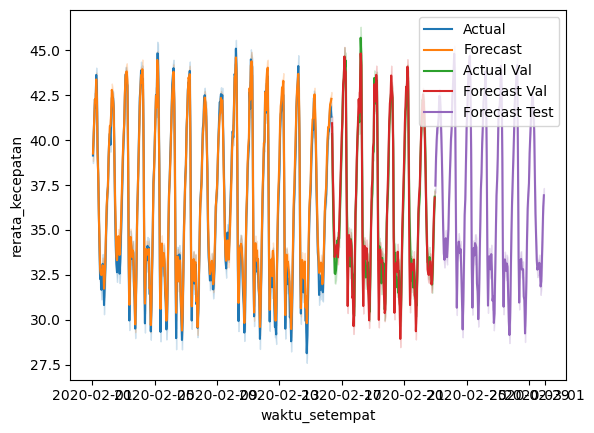

SMAPE Train : 6.670862106097841
SMAPE Val : 8.511170607594012


In [ ]:
params = {
    'objective': 'reg:absoluteerror', 'max_depth': 9, 'learning_rate': 0.057615373815915076, 'subsample': 0.9472185022329351, 'colsample_bytree': 0.9884303771152002,
    'colsample_bylevel': 0.6905397192410324, 'colsample_bynode': 0.42599594118942047, 'reg_lambda': 1.8752452391834855e-05, 'reg_alpha': 2.137831225080401,
    'grow_policy': 'lossguide', 'tree_method': 'exact', 'n_estimators' : 5000,
}
xgb = XGBRegressor(random_state = 0, eval_metric = smape, n_jobs = -1, **params)
xgb.fit(
    xtrain_tree, ytrain,
    eval_set = [(xval_tree, yval)],
    early_stopping_rounds = 200,
    verbose = 100
)
y_xgb = pd.Series(
    xgb.predict(xtrain_tree),
    index = xtrain.index
)
yhat_xgb = pd.Series(
    xgb.predict(xval_tree),
    index = xval.index
)
ytest_xgb = pd.Series(
    xgb.predict(xtest_tree),
    index = xtest.index
)
sns.lineplot(x = xtrain.index.to_timestamp(), y = ytrain, label = 'Actual')
sns.lineplot(x = xtrain.index.to_timestamp(), y = y_xgb, label = 'Forecast')
sns.lineplot(x = xval.index.to_timestamp(), y = yval, label = 'Actual Val')
sns.lineplot(x = xval.index.to_timestamp(), y = yhat_xgb, label = 'Forecast Val')
sns.lineplot(x = xtest.index.to_timestamp(), y = ytest_xgb, label = 'Forecast Test')
plt.show()

print(f'SMAPE Train : {smape(ytrain, y_xgb)}')
print(f'SMAPE Val : {smape(yval, yhat_xgb)}')

In [ ]:
sub['rerata_kecepatan'] = ytest_xgb.values
sub

,id,rerata_kecepatan
0,0,42.578129
1,1,41.555573
2,2,36.775581
3,3,44.324886
4,4,29.585699
...,...,...
127484,127484,31.439980
127485,127485,36.735310
127486,127486,41.382542
127487,127487,34.539688


In [ ]:
sub.to_csv('submission.csv', index = False)